# Exercise 3

## Occupancy grid mapping

The aim of this assignment is to implement a 2D occupancy grid mapping algorithm as described in the lecture. We provide data recorded by a robot using a 2D laser scanner in an indoor environment. 

The raw data is arranged in the following manner:

- `poses.data`: contains the **known** robot poses as it moves around the environment. Each line corresponds to the pose of the robot at a time instant

- `ranges.data`: contains 2d laser range measurements recorded by the robot. Each line corresponds to the range measurements taken from the corresponding robot poses.

---

### Log odds to probability

The occupancy calculations are usually performed using the log odds. We will need to convert between log odds and probabilities in this exercise. Implement the `logodds2prob` and `prob2logodds` functions. Verify that the conversion functions are correct for some test input. **[2.0]**

In [1]:
import numpy as np

# (1) Explore the data
poses = np.loadtxt("poses.data", delimiter=',', dtype='float')

print(poses.shape)
print(f'count (no measurement) (poses): { len(np.where(poses == np.inf)) }')
print(f'Sample (poses) (x, y, theta): { poses[np.random.randint(0, len(poses) - 1)] }\n')

ranges = np.loadtxt("ranges.data", delimiter=',', dtype='float')

print(ranges.shape)
print(f'count (no measurement) (ranges): { len(np.where(ranges == np.inf)) }')
print(f'Sample (ranges)(per beam): { ranges[np.random.randint(0, len(ranges) - 1)] }')

# poses: x_t = [x, y, theta].T
# range: z_t = [d_x, d_y]

(686, 3)
count (no measurement) (poses): 2
Sample (poses) (x, y, theta): [20.613568 14.81868   0.263018]

(686, 361)
count (no measurement) (ranges): 2
Sample (ranges)(per beam): [ 9.67  9.67  9.67  9.67  9.67  9.67  9.68  9.66  9.67  9.67  6.93  6.15
  6.34  7.1   7.11  7.11  7.14  6.77  6.43  5.93  5.7   5.29  5.12  4.78
  4.64  4.37  4.24  4.    3.93  3.7   3.62  3.44  3.38  3.21  3.16  3.01
  2.99  2.85  2.82  2.7   2.67  2.56  2.54  2.42  2.42  2.31  2.3   2.22
  2.21  2.12  2.12  2.04  2.04  1.96  1.96  1.9   1.89  1.83  1.83  1.76
  1.76  1.71  1.71  1.66  1.66  1.61  1.61  1.56  1.57  1.53  1.53  1.49
  1.49  1.45  1.45  1.41  1.41  1.37  1.38  1.35  1.36  1.32  1.34  1.34
  1.35  1.36  1.37  1.37  1.39  1.4   1.41  1.43  1.44  1.46  1.47  1.48
  1.5   1.52  1.53  1.55  1.55  1.57  1.58  1.6   1.62  1.63  1.65  1.67
  1.69  1.71  1.73  1.75  1.77  1.8   1.82  1.85  1.86  1.89  1.92  1.95
  1.98  2.    2.03  2.07  2.1   2.13  2.17  2.21  2.25  2.28  2.34  2.38
  2.42  2.48  2.53

Probabilities to log odds:

$l(m_{i}, z_{t}, x_{t}) = log\bigg(\frac{p(m_{i} | z_{t}, x_{t})}{1 - p(m_{i} | z_{t}, x_{t})}\bigg)$

Log odds to probabilities:

$p(m_{i} | z_{t}, x_{t}) = 1 - \frac{1}{1 + e^{l(m_{i}, z_{t}, x_{t})}}$

In [2]:
from ex3 import prob2logodds, logodds2prob

# Assume:
p_input = 0.75

odds = (prob2logodds(p_input))
print(f'Odds: {odds}')

prob =  (logodds2prob(odds))
print(f'Prob: {prob}')

Odds: 1.1
Prob: 0.75


---
### Inverse sensor model

The occupancy grid mapping relies on as inverse sensor model to update the occupancy of a cell in the grid. For this exercise, we consider a simple sensor model, where the occupancy of cell $m_i$ is $P_{occ}$ if the measurement $z_t$ falls in that cell, otherwise the occupancy is $P_{free}$. 

However, if the cell $m_i$ is not in the perception field, the occupancy will be $P_{prior}$.

Use the  following probabilities in the implementation:
$$P_{occ} = 0.9, P_{free} = 0.35, P_{prior} = 0.5 $$

Implement the inverse sensor model function and verify that it is correct for some test input. **[2.0]**

Inverse sensor model:
    
$l(m_{i}, z_{t}, x_{t}) = log\bigg(\frac{p(m_{i} | z_{t}, x_{t})}{1 - p(m_{i} | z_{t}, x_{t})}\bigg)$

[[ 3.    1.    0.35]
 [ 4.    2.    0.35]
 [ 5.    3.    0.35]
 [ 5.    4.    0.35]
 [ 6.    5.    0.35]
 [ 7.    6.    0.35]
 [ 8.    7.    0.35]
 [ 9.    8.    0.35]
 [10.    9.    0.35]
 [10.   10.    0.35]
 [11.   11.    0.35]
 [12.   12.    0.9 ]]


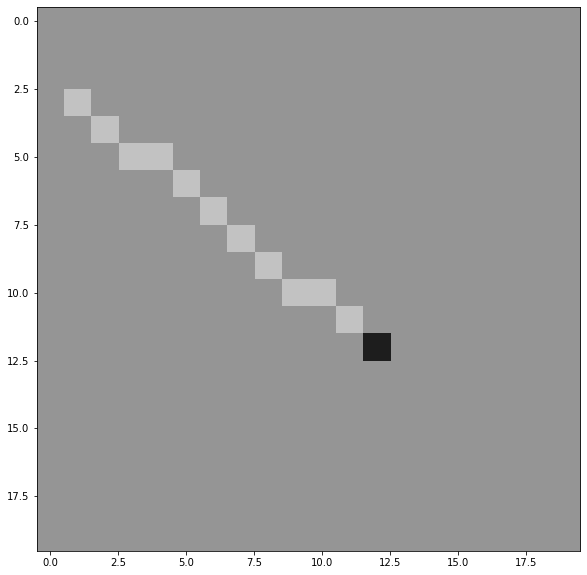

In [3]:
from ex3 import *

cell = [3, 1]
endpoint = [12, 12]

prob_occ = 0.9
prob_free = 0.35

sensor_model = inv_sensor_model(cell, endpoint, prob_occ, prob_free)

print(sensor_model)

prior = 0.5
occ_gridmap = init_gridmap(20, 1) + prior

for triplet in sensor_model:
    occ_gridmap[int(triplet[0])][int(triplet[1])] = triplet[2]
    
plot_gridmap(occ_gridmap)

---
### Occupancy grid mapping algorithm:

Implement the occupancy grid mapping algorithm as described in lecture slides. 

We provide some functions to make the implemntation easier.

- `ranges2cells` converts the raw measurements acquired by the robot (*ranges_raw*) into the correspoding cells of the gridmap.
- `poses2cells` converts the raw poses of the robot (*poses_raw*) into the correspoding cells of the gridmap.
- `bresenham` returns all the cells along a straigh line between two points in the gridmap.

Other parameters you may need in the implemntation are provided below.

Implement the `grid_mapping_with_known_poses` functionn and compute the resulting occupancy grid map using all the measurements provided in the data.

Plot the final occupancy gridmap using the `plot_gridmap` function. **[6.0]**


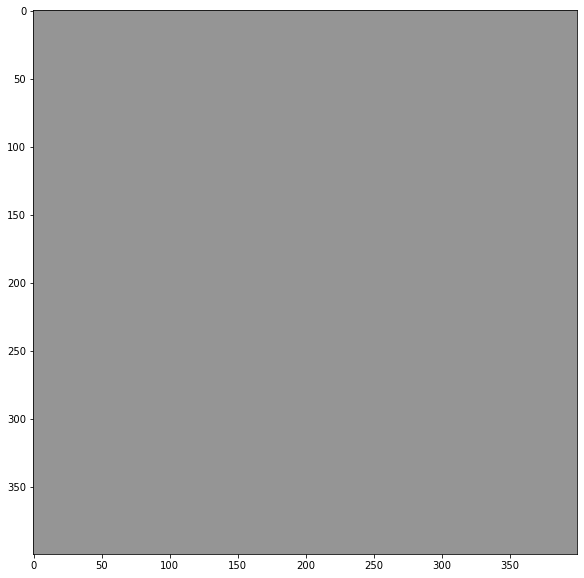

In [4]:
import ex3
import numpy as np
%matplotlib inline

map_size = 100
map_res = 0.25

prior = 0.50
prob_occ = 0.90
prob_free = 0.35

# load data
ranges_raw = np.loadtxt("ranges.data", delimiter=',', dtype='float')
poses_raw = np.loadtxt("poses.data", delimiter=',', dtype='float')

# initialize gridmap
occ_gridmap = ex3.init_gridmap(map_size, map_res) + prior
ex3.plot_gridmap(occ_gridmap)

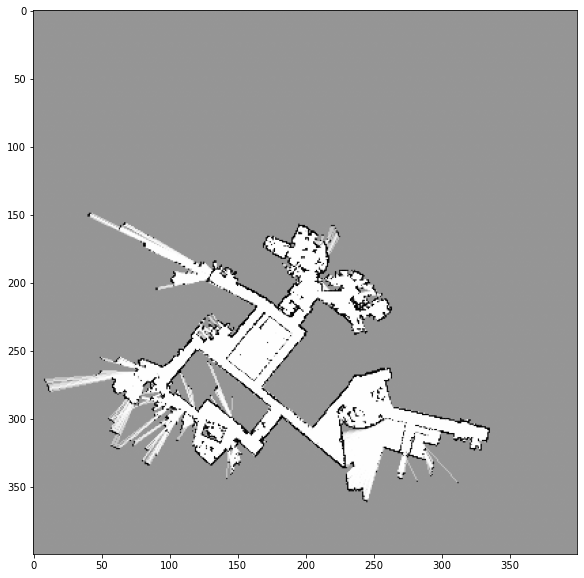

In [5]:
from ex3 import grid_mapping_with_known_poses

occ_gridmap = grid_mapping_with_known_poses(ranges_raw, poses_raw, occ_gridmap, map_res, prob_occ, prob_free, prior)
ex3.plot_gridmap(occ_gridmap)